In [4]:
import dota2api
import pandas as pd
import json
from pprint import pprint 
import os
import numpy as np
import sqlite3
import re

In [5]:
api = dota2api.Initialise("51F97BBEFA8852349EAC075EF0D1D36E")
N_HEROS = 115

In [135]:
db = sqlite3.connect("./dota_jsons.db")
HERO_NAMES = [];

In [136]:
HERO_NAMES = [i['localized_name'] for i in api.get_heroes()['heroes']]
HERO_NAMES

['Anti-Mage',
 'Axe',
 'Bane',
 'Bloodseeker',
 'Crystal Maiden',
 'Drow Ranger',
 'Earthshaker',
 'Juggernaut',
 'Mirana',
 'Shadow Fiend',
 'Morphling',
 'Phantom Lancer',
 'Puck',
 'Pudge',
 'Razor',
 'Sand King',
 'Storm Spirit',
 'Sven',
 'Tiny',
 'Vengeful Spirit',
 'Windranger',
 'Zeus',
 'Kunkka',
 'Lina',
 'Lich',
 'Lion',
 'Shadow Shaman',
 'Slardar',
 'Tidehunter',
 'Witch Doctor',
 'Riki',
 'Enigma',
 'Tinker',
 'Sniper',
 'Necrophos',
 'Warlock',
 'Beastmaster',
 'Queen of Pain',
 'Venomancer',
 'Faceless Void',
 'Wraith King',
 'Death Prophet',
 'Phantom Assassin',
 'Pugna',
 'Templar Assassin',
 'Viper',
 'Luna',
 'Dragon Knight',
 'Dazzle',
 'Clockwerk',
 'Leshrac',
 "Nature's Prophet",
 'Lifestealer',
 'Dark Seer',
 'Clinkz',
 'Omniknight',
 'Enchantress',
 'Huskar',
 'Night Stalker',
 'Broodmother',
 'Bounty Hunter',
 'Weaver',
 'Jakiro',
 'Batrider',
 'Chen',
 'Spectre',
 'Doom',
 'Ancient Apparition',
 'Ursa',
 'Spirit Breaker',
 'Gyrocopter',
 'Alchemist',
 'Invoke

In [952]:
N_HEROS = 121
cursor = db.execute("SELECT * FROM DATA")
n_matches = 0
for i in cursor:
    n_matches+=1
print(n_matches)
n_fails = 0
id_list = []
bag_set_heros = set([])

data = np.empty((n_matches, 10), dtype=int)
fb_time = np.empty((n_matches), dtype=int)
game_time = np.empty((n_matches), dtype=int)
label = np.empty(n_matches)
cursor = db.execute("SELECT * FROM DATA")
carry_have_bkb = np.empty((n_matches,2), dtype=bool)
bkb_count = np.zeros((n_matches,2), dtype=int)
midas_count = np.zeros((n_matches,2), dtype=int)
match_ids = []
std = np.empty((n_matches, 2), dtype=float) ##gpm_std
std_xpm = np.empty((n_matches, 2), dtype=float) ##xpm_std xp_per_min


k = 0
count = 0
for cur in cursor:
    mystr = re.sub("'", '"', cur[1])
    mystr = re.sub('(?<=\w)"s', "'s", mystr)
    mystr = re.sub('False', '"False"', mystr)
    mystr = re.sub('(?<=(: ))True', '"True"', mystr)

    try:
        match = json.loads(mystr)
        if (match['game_mode'] == 22):
            count += 1
        else:
            continue
        label[k] = 1 if match['radiant_win']=='True' else 0
        hero_set = np.array([match['players'][i]['hero_id'] for i in range(10)])
        
        fb_time[k] = match['first_blood_time']
        game_time[k] = match['duration']
        
        #находим керри и смотрим есть у него бкб или нет
        radiant_with_max_gpm = np.argmax([match['players'][i]['gold_per_min'] for i in range(0,5)])
        dire_with_max_gpm    = np.argmax([match['players'][i]['gold_per_min'] for i in range(5,10)])+5
        radiant = match['players'][radiant_with_max_gpm]
        dire    = match['players'][dire_with_max_gpm]

        carry_have_bkb[k] = ('\'Black King Bar\'' in str(radiant), '\'Black King Bar\'' in str(dire))
        match_ids.append(match['match_id'])
        for i in range (0,5):
            radiant = match['players'][i]
            dire    = match['players'][i+5]
            if('\'Black King Bar\'' in str(radiant)):
                bkb_count[k,0]+=1
            if('\'Black King Bar\'' in str(dire)):
                bkb_count[k,1]+=1
                
            if('\'Hand of Midas\'' in str(radiant)):
                midas_count[k,0]+=1
            if('\'Hand of Midas\'' in str(dire)):
                midas_count[k,1]+=1
        
        gpms_radiant = []
        gpms_dire = []
        for i in range(5):
            gpms_radiant.append(match['players'][i]['gold_per_min'])
            gpms_dire.append(match['players'][i+5]['gold_per_min'])
        std[k] = (np.array(gpms_radiant).std(), np.array(gpms_dire).std())
        
        xpms_radiant = []
        xpms_dire = []
        for i in range(5):
            xpms_radiant.append(match['players'][i]['xp_per_min'])
            xpms_dire.append(match['players'][i+5]['xp_per_min'])
        std_xpm[k] = (np.array(xpms_radiant).std(), np.array(xpms_dire).std())
        
        for i in range(10):
            id_list.append(hero_set[i])
            
        hero_set[5:] += N_HEROS
        data[k] = hero_set.astype(int)
        k+=1
    except Exception as e:
        #print(e)
        pass    

n_matches = k
data = data[:k]
label = label[:k]
fb_time = fb_time[:k]
game_time = game_time[:k]
carry_have_bkb = carry_have_bkb[:k]
bkb_count = bkb_count[:k]
midas_count = midas_count[:k]
std = std[:k]
std_xpm = std_xpm[:k]
print(count)
print(n_matches)

79078
43397
40690


In [956]:
match['duration']


In [450]:
N_HEROS=121
final_data = np.zeros((n_matches, N_HEROS*2), dtype=int)
for i in range(n_matches):
    final_data[i][data[i]] = 1
final_data = final_data[:, final_data.sum(axis=0)!=0]

N_HEROS = final_data.shape[1] // 2
print(N_HEROS)

final_data2 = np.zeros((2*n_matches, N_HEROS), dtype=int)
final_data2[:n_matches] = final_data[:, :N_HEROS]
final_data2[n_matches:] = final_data[:, N_HEROS:]

final_data3 = np.zeros((2*n_matches, 2*N_HEROS), dtype=int)
final_data3[:n_matches] = final_data
final_data3[n_matches:, :N_HEROS] = final_data[:, N_HEROS:]
final_data3[n_matches:, N_HEROS:] = final_data[:, :N_HEROS]

y = label
y2 = np.zeros(2*n_matches, dtype=int)
y2[:n_matches] = y
y2[n_matches:] = np.abs(1 - y)
y3 = np.zeros(2*n_matches, dtype=int)
y3 = y2

115


In [41]:
norm_data = (final_data - final_data.mean(axis=1).reshape((-1,1))) / final_data.std(axis=1).reshape((-1,1))
norm_data2 = (final_data2 - final_data2.mean(axis=1).reshape((-1,1))) / final_data2.std(axis=1).reshape((-1,1))
norm_data3 = (final_data3 - final_data3.mean(axis=1).reshape((-1,1))) / final_data3.std(axis=1).reshape((-1,1))

In [84]:
from sklearn.cross_validation import train_test_split
# X_train,X_test,y_train,y_test = train_test_split(norm_data3,y3,test_size=0.2)

In [93]:
indeces = np.arange(n_matches)
np.random.shuffle(indeces)

In [94]:
n_train = int(0.8 * n_matches)

train_indeces = indeces[:n_train]
test_indeces =  indeces[n_train:]
X_train2 = np.concatenate((final_data2[train_indeces],final_data2[train_indeces+n_matches]))
y_train2 = np.concatenate((y2[train_indeces],y2[train_indeces+n_matches]))

In [95]:
pairs = np.zeros((N_HEROS,N_HEROS))
for i in range(N_HEROS):
    for j in range(i+1,N_HEROS):
        _set_ = X_train2[:, i] * X_train2[:, j]
        if _set_.sum() > 10:
            pairs[i,j] = (_set_* y_train2).sum() / _set_.sum()

print(np.sort(pairs.reshape((-1)))[-10:])
pairs = pairs + pairs.T

[0.81818182 0.81818182 0.82352941 0.83333333 0.83333333 0.83333333
 0.83870968 0.85714286 0.86666667 0.90909091]


In [96]:
for i in range(n_matches):
    a = np.arange(N_HEROS)[final_data[i, :N_HEROS].astype(bool)]
    if a.size != 5:
        print(i, final_data[i, :N_HEROS])

In [97]:
# X_train, y_train = final_data[train_indeces], y[train_indeces]
# X_test, y_test = final_data[test_indeces], y[test_indeces]

In [98]:
extra_data = np.zeros((n_matches, 2))
for i in range(n_matches):
    _set_ = np.arange(N_HEROS)[final_data[i, :N_HEROS].astype(bool)]
    
    for ii in range(5):
        for jj in range(ii+1, 5):
            #print(_set_[ii], _set_[jj])
            score = pairs[_set_[ii],_set_[jj]]
            extra_data[i,0] += score
            
    _set_ = np.arange(N_HEROS)[final_data[i, N_HEROS:].astype(bool)]
    for ii in range(5):
        for jj in range(ii+1, 5):
            score = pairs[_set_[ii],_set_[jj]]
            extra_data[i,1] += score

In [99]:
extra_data

array([[4.59078392, 5.11071557],
       [4.42629076, 5.43697744],
       [4.71037501, 5.38922121],
       ...,
       [5.07007053, 5.05584304],
       [5.72947417, 4.8597506 ],
       [5.15944567, 5.48801112]])

In [102]:
my_ans = np.array([1 if extra_data[i,0] >= extra_data[i,1] else 0 for i in range(n_matches)])
print((my_ans == y).sum() / n_matches)

X_test, y_test = extra_data[test_indeces], y[test_indeces]
my_ans = np.array([1 if X_test[i,0] >= X_test[i,1] else 0 for i in range(n_matches-n_train)])
print((my_ans == y_test).sum() / (n_matches-n_train))

0.6470011861172709
0.562773910801753


In [103]:
efinal_data = np.concatenate((final_data, extra_data), axis=1)
X_train, y_train = efinal_data[train_indeces], y[train_indeces]
X_test, y_test = efinal_data[test_indeces], y[test_indeces]

In [104]:
my_ans = np.array([1 if extra_data[i,0] >= extra_data[i,1] else 0 for i in range(n_matches)])
print((my_ans == y).sum() / n_matches)

0.6470011861172709


In [56]:
from sklearn import svm
clf = svm.SVC(C = 100)
clf.fit(X_train, y_train)
svm_score = clf.score(X_test, y_test)
# svm_ans = clf.predict(X_test)
print(svm_score)

0.5354472802268626


In [57]:
from sklearn.neighbors import KNeighborsClassifier as KNN
clf = KNN(n_neighbors=1)
clf.fit(X_train, y_train)
knn_score = clf.score(X_test, y_test)
print(knn_score)
# knn_ans = clf.predict_proba(X_test)
# print(knn_ans[:15])

0.5215261665377675


In [118]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, max_depth=1000)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
tree_ans = clf.predict(X_test).sum()
X_test.shape[0]

0.5650940964166022


3879

In [107]:
# import matplotlib.pyplot as plt
# plt.bar(range(N_HEROS), final_data2.sum(axis=0))

Предсказываем  Время First Blood

График количества First Blood от времени


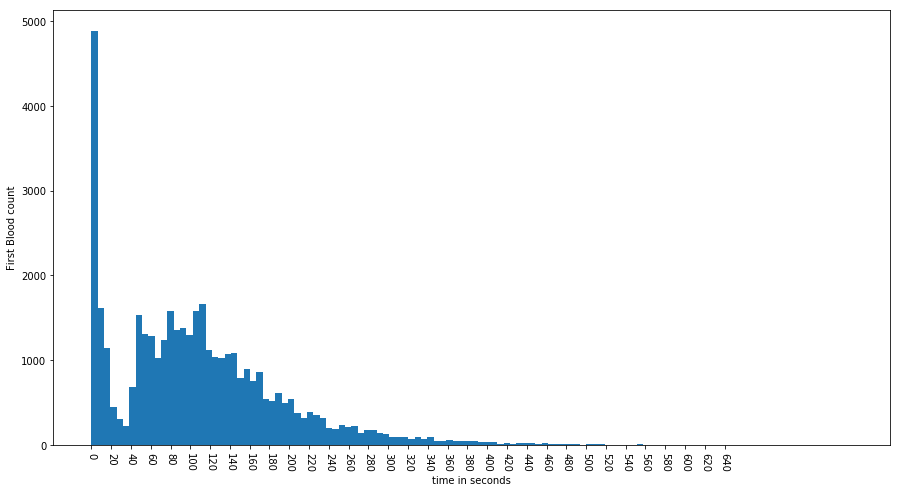

In [431]:
import matplotlib.pyplot as plt
print("График количества First Blood от времени")
plt.rcParams['figure.figsize'] = (15,8)
plt.hist(np.sort(fb_time), bins = 120)
plt.xticks([i*20 for i in range(33)], rotation = 270)
plt.xlabel("time in seconds")
plt.ylabel("First Blood count")
plt.show()

График времени игры


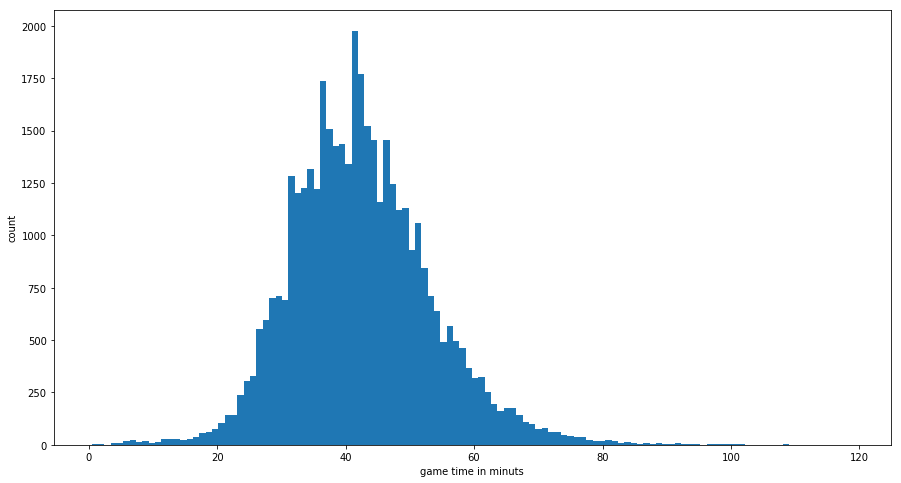

In [430]:
print("График времени игры")
plt.rcParams['figure.figsize'] = (15,8)
plt.hist(np.sort(game_time)/60, bins = 120)
#plt.xticks([i*120 for i in range(50)], rotation = 270)
plt.xlabel("game time in minuts")
plt.ylabel("count")
plt.show()

График среднего времени игры в зависимости от присутствия героя
(40690, 230)


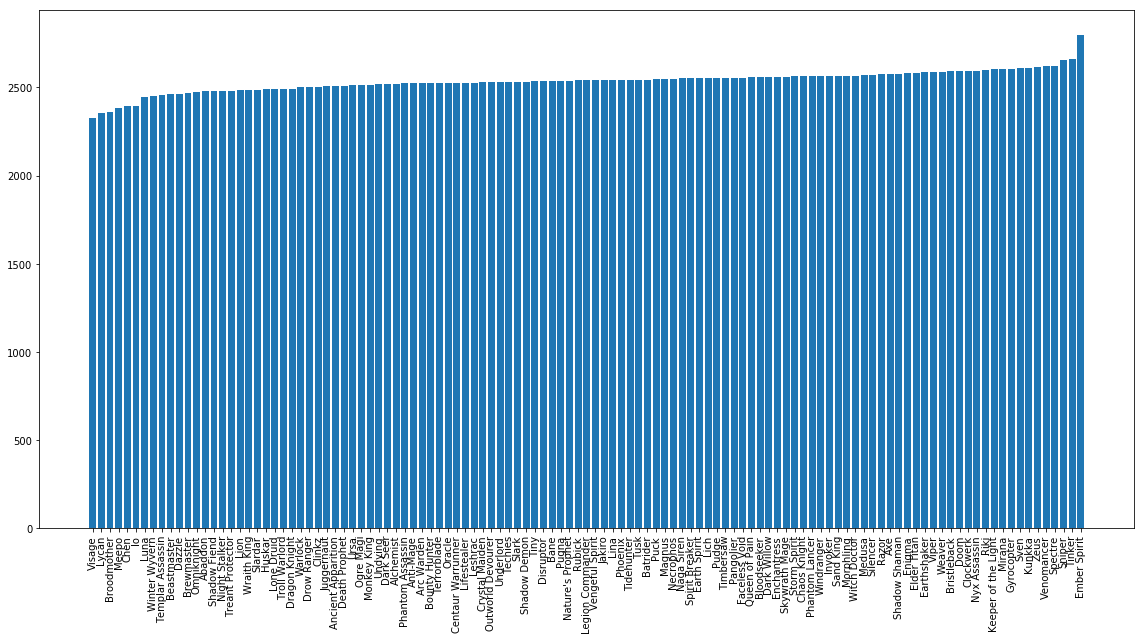

In [490]:
plt.rcParams['figure.figsize'] = (16,9)
print("График среднего времени игры в зависимости от присутствия героя")

awerage_game_time_by_hero = np.zeros(len(HERO_NAMES))
print(final_data.shape)
for i in range(len(HERO_NAMES)):
    for j in range(game_time.shape[0]):
        if(final_data[j,i] == 1 or final_data[j,i+N_HEROS] == 1):
            awerage_game_time_by_hero[i]+=game_time[j]
for i in range(len(HERO_NAMES)):
    awerage_game_time_by_hero[i]/=(final_data[:,i] == 1).sum()+(final_data[:,i+N_HEROS] == 1).sum()

args = np.argsort(awerage_game_time_by_hero)
plt.bar(range(len(HERO_NAMES)), awerage_game_time_by_hero[args])
plt.xticks(range(len(HERO_NAMES)), np.array(HERO_NAMES)[args], rotation = 90)
plt.tight_layout()
plt.show()

График среднего времени First Blood зависимости от присутствия героя
(40690, 230)


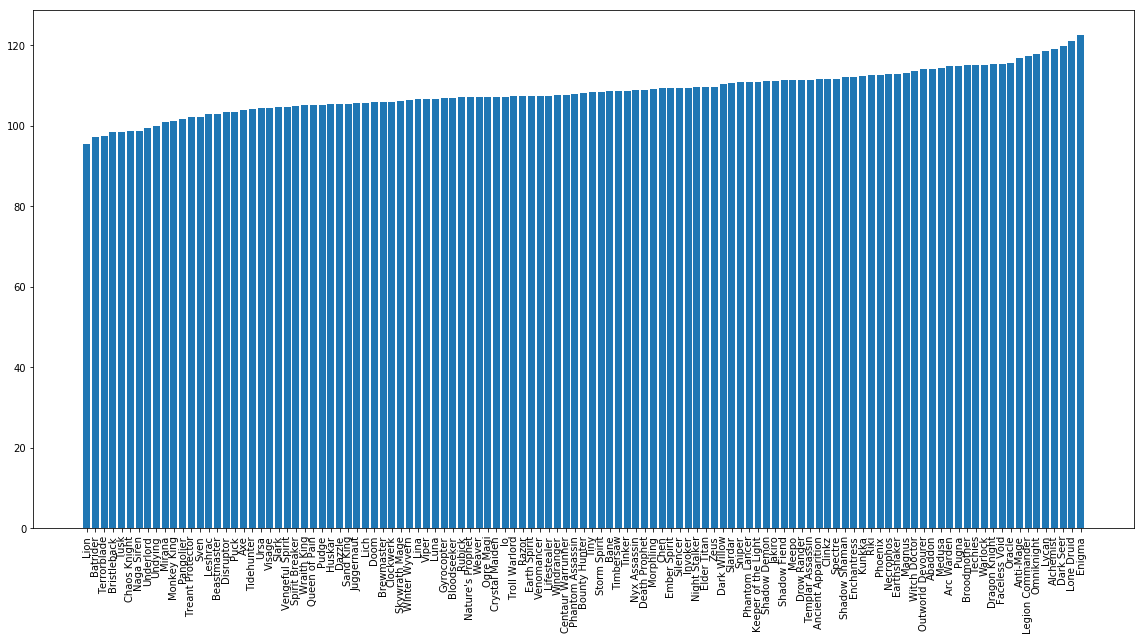

In [491]:
plt.rcParams['figure.figsize'] = (16,9)
print("График среднего времени First Blood зависимости от присутствия героя")

awerage_game_time_by_hero = np.zeros(len(HERO_NAMES))
print(final_data.shape)
for i in range(len(HERO_NAMES)):
    for j in range(game_time.shape[0]):
        if(final_data[j,i] == 1 or final_data[j,i+N_HEROS] == 1):
            awerage_game_time_by_hero[i]+=fb_time[j]
for i in range(len(HERO_NAMES)):
    awerage_game_time_by_hero[i]/=(final_data[:,i] == 1).sum()+(final_data[:,i+N_HEROS] == 1).sum()

args = np.argsort(awerage_game_time_by_hero)
plt.bar(range(len(HERO_NAMES)), awerage_game_time_by_hero[args])
plt.xticks(range(len(HERO_NAMES)), np.array(HERO_NAMES)[args], rotation = 90)
plt.tight_layout()
plt.show()

Влияние BKB на победу

In [652]:
carry_have_bkb
radiant_score = (label[carry_have_bkb[:,0]].sum()/len(label[carry_have_bkb[:,0]]))
dire_score = ((1-label[carry_have_bkb[:,1]]).sum()/len(label[carry_have_bkb[:,1]]))
print("carry radiant bkb = %s" % radiant_score )
print("carry dire    bkb = %s" % dire_score )
print("common winrate = %s" % ((radiant_score+dire_score)/2))
print("бкб не сильно влияет на победу, но всётаки влияет :)")

carry radiant bkb = 0.5503652114829285
carry dire    bkb = 0.5048755884330868
common winrate = 0.5276203999580076
бкб не сильно влияет на победу, но всётаки влияет :)


In [650]:
#процент побед команды если у нее бкб больше чем в противоположной
radiant_score = (label[bkb_count[:,0]>bkb_count[:,1]].sum()/len(label[bkb_count[:,0]>bkb_count[:,1]]))
dire_score = ((1-label[bkb_count[:,1]>bkb_count[:,0]]).sum()/len(label[bkb_count[:,1]>bkb_count[:,0]]))
print ("radiant team bkb = %s"  %  radiant_score   )
print ("dire team bkb = %s"  %  dire_score   )
print ("common winrate = %s" % ((radiant_score + dire_score)/2))

radiant team bkb = 0.6162439106332941
dire team bkb = 0.5704037370704037
common winrate = 0.5933238238518489


<Container object of 6 artists>

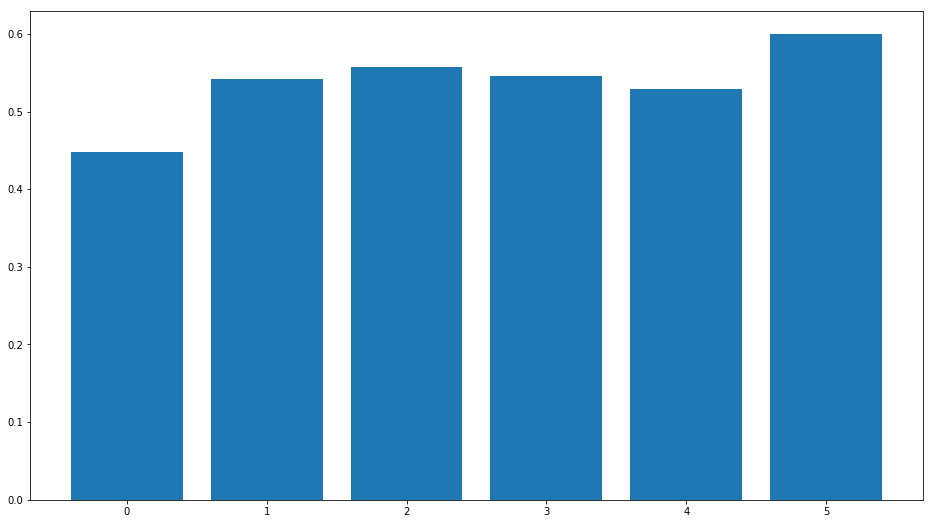

In [738]:
#виирейт от количества бкб в команде
common_score = [0,1,2,3,4,5]

for i in range(6):
    radiant_score = label[bkb_count[:,0] == i].sum() /len(label[bkb_count[:,0] == i])
    dire_score = (1-label[bkb_count[:,1] == i]).sum()/len(label[bkb_count[:,1] == i])
    common_score[i] = (radiant_score+dire_score)/2
plt.bar(range(6),common_score)

чем больше мидасов в команде тем меньше винрейт, а наличие одного ни на что не влияет


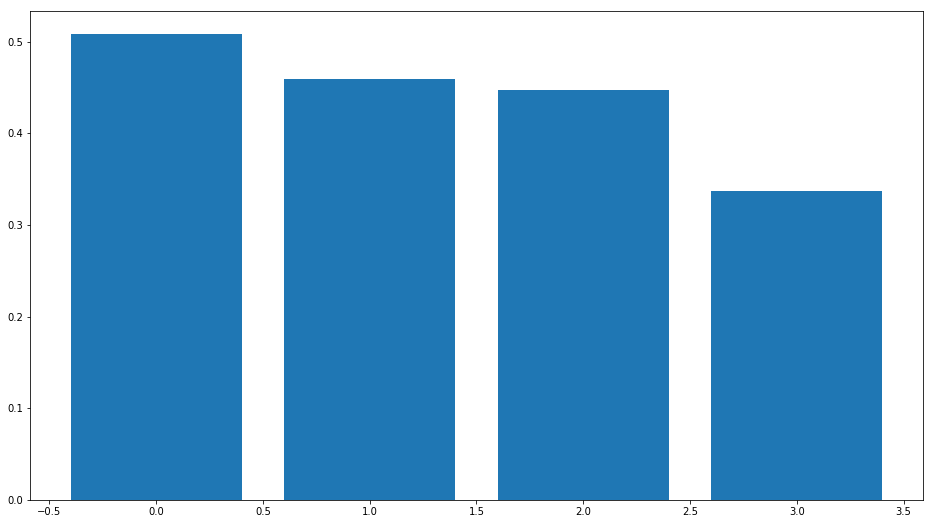

In [746]:
#винрейо от количества мирасов в команде
print ("чем больше мидасов в команде тем меньше винрейт, а наличие одного ни на что не влияет")
common_score = [0,1,2,3]

for i in range(4):
    radiant_score = label[midas_count[:,0] == i].sum() /len(label[midas_count[:,0] == i])
    dire_score = (1-label[midas_count[:,1] == i]).sum()/len(label[midas_count[:,1] == i])
    common_score[i] = (radiant_score+dire_score)/2
plt.bar(range(4),common_score)
plt.show()

Винрейт от стандартного отклонения GPM у команды

Винрейт от разброса GPM


C:\Users\alexey_py\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\alexey_py\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


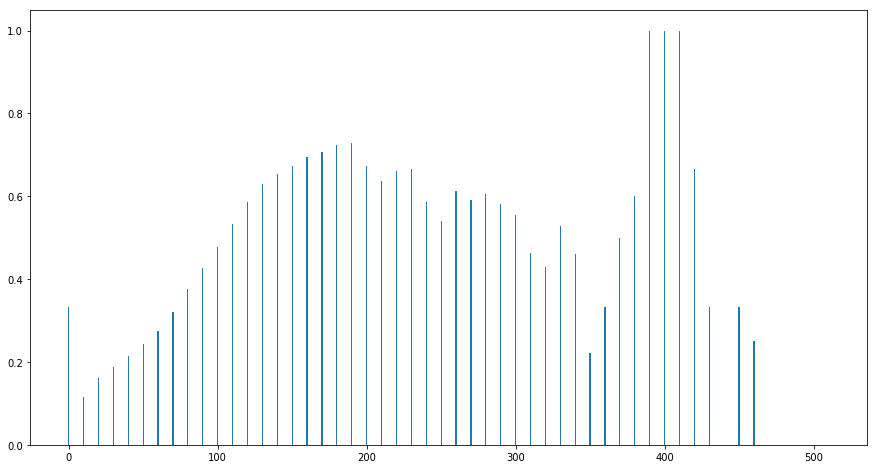

In [949]:
print("Винрейт от разброса GPM")

indexes = np.array([abs(std[:,0]-i*10)<=10 for i in range (70)])
indexes_dire = np.array([abs(std[:,1]-i*10)<=10 for i in range (70)])

win_rates = np.zeros(indexes.shape[0])
win_rates_dire = np.zeros(indexes.shape[0])

for i in range(indexes.shape[0]):
    win_rates[i] = label[indexes[i]].sum()/len(label[indexes[i]])
    win_rates_dire[i] = (1-label[indexes_dire[i]]).sum()/len(label[indexes_dire[i]])
win_rates = (win_rates + win_rates_dire)/2.
plt.bar(np.array(range(70))*10, win_rates_dire)
plt.show()

Винрейт от разброса XPM


C:\Users\alexey_py\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\alexey_py\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


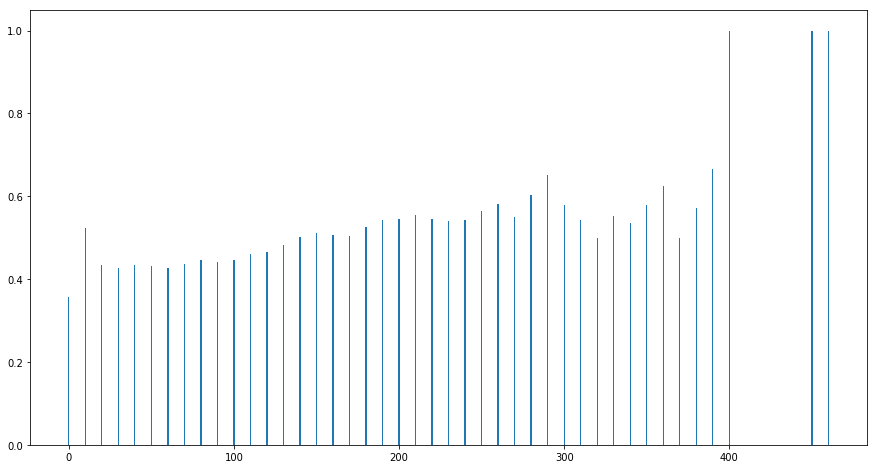

In [960]:
print("Винрейт от разброса XPM")

indexes = np.array([abs(std_xpm[:,0]-i*10)<=10 for i in range (70)])
indexes_dire = np.array([abs(std_xpm[:,1]-i*10)<=10 for i in range (70)])

win_rates = np.zeros(indexes.shape[0])
win_rates_dire = np.zeros(indexes.shape[0])

for i in range(indexes.shape[0]):
    win_rates[i] = label[indexes[i]].sum()/len(label[indexes[i]])
    win_rates_dire[i] = (1-label[indexes_dire[i]]).sum()/len(label[indexes_dire[i]])
win_rates = (win_rates + win_rates_dire)/2.
plt.bar(np.array(range(70))*10, win_rates_dire)
plt.show()

In [963]:
(std_xpm>200).sum()

3442